This one is for testing some FCNNs

In [3]:
import pandas as pd
import os, sys
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import fcnn_models

## Data Prep

In [4]:
def load_csv_data(file_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Reads the CSV with all the training data: grayscale log-mel spectrogram pixels, label and author of each sample
    And extracts them respectively, resizing the features to fit the CNN input shape (channel, height, width).

    Args:
        file_path (str): Path to the CSV file containing training data.

    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors from the CSV file. Features shape is (N x 70,112),
        while labels and authors are 1D arrays of size N, where N is the number of samples.
    """
    # Load training data
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")

    # Extract labels, authors, and features
    labels = df['label'].values.astype(np.int64)
    authors = df['author'].values
    features = df.drop(columns=['label', 'author']).values.astype(np.float32)
    print(f"Features shape before reshape: {features.shape} (should be N x 70112!)")

    # Convert to 0-1 range
    features /= 255.0

    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    print("Authors shape:", authors.shape)
    print("Unique classes:", len(np.unique(labels)))
    print("Unique authors:", len(np.unique(authors)))

    # No need for df variable after extracting features, release memory
    del df

    return features, labels, authors

Dataset shape: (2987, 70114)
Number of classes: 33
Number of authors: 106
Features shape before reshape: (2987, 70112) (should be N x 70112!)
Features shape: (2987, 70112)
Labels shape: (2987,)
Authors shape: (2987,)
Unique classes: 33
Unique authors: 106


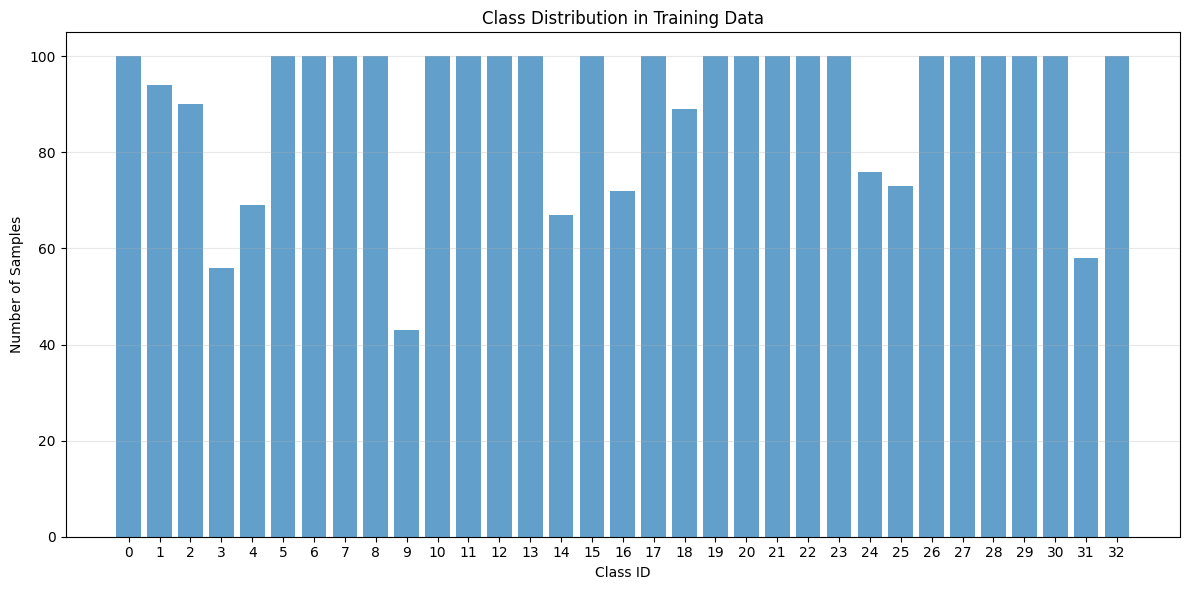

Average samples per class: 90.5


In [5]:
# Keep the old CSV-based loading for compatibility (uncomment if needed)
train_data_path = os.path.join('..', 'database', 'meta', 'final', 'train_data.csv')
features, labels, authors = load_csv_data(train_data_path)

# Display class distribution
plt.figure(figsize=(12, 6))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

In [6]:
# Split with a set seed, las que ya encontre arriba, para tardar menos
from utils.split import get_set_seed_indices, display_split_statistics
seed_single = 245323 # Quality: 0.2671

train_indices, val_indices, best_score, seed = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

# Extract train and validation data using indices
trFeatures = features[train_indices]
trLabels = labels[train_indices]
trAuthors = authors[train_indices]

vFeatures = features[val_indices]
vLabels = labels[val_indices]
vAuthors = authors[val_indices]

print(f"Training set: {trFeatures.shape[0]} samples")
print(f"Validation set: {vFeatures.shape[0]} samples")
print(f"Split quality score: {best_score}")

display_split_statistics((train_indices, val_indices, best_score, seed), "single")

# Convert labels to one-hot encoding for BirdFCNN_v0 model
num_classes = len(np.unique(labels))

Training set: 2330 samples
Validation set: 657 samples
Split quality score: 0.26713002574246597

📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2330
Validation samples: 657
Split ratio: 78.00% - 22.00%
Quality score: 0.2671
----------------------------------------


In [8]:
from utils.fcnn_models import BirdFCNN, BirdFCNN_v0, BirdFCNN_v1, BirdFCNN_v2, BirdFCNN_v3, BirdFCNN_v4, BirdFCNN_v5, BirdFCNN_v6, BirdFCNN_v7, BirdFCNN_v8, BirdFCNN_v9, BirdFCNN_v10, BirdFCNN_v11, BirdFCNN_v12, BirdFCNN_v13, BirdFCNN_v14
from utils.metrics import plot_full_metrics

# Models List
models = {
    'BirdFCNN': BirdFCNN,
    'BirdFCNN_v0': BirdFCNN_v0,
    'BirdFCNN_v1': BirdFCNN_v1,
    'BirdFCNN_v2': BirdFCNN_v2,
    'BirdFCNN_v3': BirdFCNN_v3,
    'BirdFCNN_v4': BirdFCNN_v4,
    'BirdFCNN_v5': BirdFCNN_v5,
    'BirdFCNN_v6': BirdFCNN_v6,
    'BirdFCNN_v7': BirdFCNN_v7,
    'BirdFCNN_v8': BirdFCNN_v8,
    'BirdFCNN_v9': BirdFCNN_v9,
    'BirdFCNN_v10': BirdFCNN_v10,
    'BirdFCNN_v11': BirdFCNN_v11,
    'BirdFCNN_v12': BirdFCNN_v12,
    'BirdFCNN_v13': BirdFCNN_v13,
    'BirdFCNN_v14': BirdFCNN_v14
}

## Training

In [ ]:
# Model sweeping - train all models with their individual configurations and save as .pth
import time
from collections import defaultdict
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Base training configuration (will be overridden by each model's specific config)
base_training_config = {
    'epochs': 200,
    'early_stopping': True,
    'patience': 25,
    'eval_interval': 1,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {base_training_config['device']}")
print(f"Training {len(models)} models with individual configurations")
print("="*70)

# Store results for all models
all_results = {}
saved_models = {}

for model_name, model_class in models.items():
    print(f"\n🔥 Training {model_name}...")
    start_time = time.time()
    
    # Initialize model
    model = model_class(num_classes=num_classes, input_dim=trFeatures.shape[1])
    
    # Train model with its own configuration and get results
    results = model.train_model(
        trainX=trFeatures,
        trainY=trLabels,  # Use integer labels for PyTorch models
        valX=vFeatures,
        valY=vLabels,
        **base_training_config  # Each model will override with its own defaults
    )
    
    # Store results
    all_results[model_name] = results
    
    # Save the trained model as .pth file
    # model_path = os.path.join('..', 'models', f'{model_name.lower()}_sweep.pth')
    # model.save_model(model_path)
    # saved_models[model_name] = model_path
    
    training_time = time.time() - start_time
    print(f"✅ {model_name} completed in {training_time:.2f} seconds")
    print(f"   Best Val Accuracy: {results['best_val_acc']:.4f}")
    print(f"   Best Val F1: {results['best_val_f1']:.4f}")
    # print(f"   Model saved: {model_path}")
    print("-" * 50)

print("\n🎉 All models trained successfully!")
# print(f"💾 Models saved to: {list(saved_models.values())}")
print("="*70)

## Results

In [ ]:
# Plot results for all models
print("📊 Plotting results for all models...")
print("="*50)

for model_name, results in all_results.items():
    print(f"Plotting {model_name}...")
    plot_full_metrics(model_name, results['history'], results['confusion_matrix'])

print("\n🎯 Model Performance Summary:")
print("="*50)

# Create summary table
summary_data = []
for model_name, results in all_results.items():
    summary_data.append({
        'Model': model_name,
        'Best Val Accuracy': f"{results['best_val_acc']:.4f}",
        'Best Val F1': f"{results['best_val_f1']:.4f}",
        'Final Train Loss': f"{results['history']['train_losses'][-1]:.4f}",
        'Final Val Loss': f"{results['history']['val_losses'][-1]:.4f}"
    })

# Sort by validation accuracy
summary_data.sort(key=lambda x: float(x['Best Val Accuracy']), reverse=True)

# Display summary table
import pandas as pd
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n🏆 Best model by validation accuracy: {summary_data[0]['Model']}")
print(f"🥈 Second best: {summary_data[1]['Model']}")
print(f"🥉 Third best: {summary_data[2]['Model']}")

# Plot comparative bar chart
plt.figure(figsize=(15, 10))

# Extract metrics for plotting
model_names = [item['Model'] for item in summary_data]
val_accuracies = [float(item['Best Val Accuracy']) for item in summary_data]
val_f1s = [float(item['Best Val F1']) for item in summary_data]

# Subplot 1: Validation Accuracy Comparison
plt.subplot(2, 2, 1)
bars1 = plt.bar(range(len(model_names)), val_accuracies, alpha=0.7, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val_accuracies[i]:.3f}', ha='center', va='bottom', fontsize=9)

# Subplot 2: F1 Score Comparison
plt.subplot(2, 2, 2)
bars2 = plt.bar(range(len(model_names)), val_f1s, alpha=0.7, color='lightcoral')
plt.xlabel('Models')
plt.ylabel('Validation F1 Score')
plt.title('Validation F1 Score Comparison')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, bar in enumerate(bars2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val_f1s[i]:.3f}', ha='center', va='bottom', fontsize=9)

# Subplot 3: Training vs Validation Loss (final values)
plt.subplot(2, 2, 3)
final_train_losses = [float(item['Final Train Loss']) for item in summary_data]
final_val_losses = [float(item['Final Val Loss']) for item in summary_data]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, final_train_losses, width, label='Train Loss', alpha=0.7, color='green')
plt.bar(x + width/2, final_val_losses, width, label='Val Loss', alpha=0.7, color='orange')

plt.xlabel('Models')
plt.ylabel('Final Loss')
plt.title('Final Training vs Validation Loss')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Subplot 4: Accuracy vs F1 scatter plot
plt.subplot(2, 2, 4)
plt.scatter(val_accuracies, val_f1s, alpha=0.7, s=100, c='purple')
plt.xlabel('Validation Accuracy')
plt.ylabel('Validation F1 Score')
plt.title('Accuracy vs F1 Score')
plt.grid(True, alpha=0.3)

# Add model name labels to points
for i, model_name in enumerate(model_names):
    plt.annotate(model_name, (val_accuracies[i], val_f1s[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✨ Model sweep completed! Check the plots above for detailed comparisons.")

In [ ]:
# Save the best model and provide recommendations
# The best model is already saved, so we just need to identify it

# Find the best model
best_model_name = summary_data[0]['Model']
best_model_path = saved_models[best_model_name]
print(f"🏆 Best performing model: {best_model_name}")
print(f"📁 Best model file: {best_model_path}")

print("\n" + "="*60)
print("📝 MODEL SWEEP ANALYSIS & RECOMMENDATIONS")
print("="*60)

print(f"\n🎯 PERFORMANCE RANKING:")
for i, item in enumerate(summary_data[:3], 1):
    print(f"{i}. {item['Model']}: Val Acc = {item['Best Val Accuracy']}, Val F1 = {item['Best Val F1']}")

print(f"\n💡 ARCHITECTURE & TRAINING INSIGHTS:")
model_configs = {
    'BirdFCNN_v0': "Baseline [512, 256, 128] + SGD + lr=0.01 + batch=64",
    'BirdFCNN': "Standard [512, 128, 32] + Adam + lr=0.001 + batch=32",
    'BirdFCNN_v2': "Deep [256, 128, 64, 32, 16] + Adam + lr=0.0005 + exp_decay + batch=16",
    'BirdFCNN_v3': "Wide [1024, 512] + Adam + lr=0.002 + batch=64",
    'BirdFCNN_v4': "Low dropout [512, 128, 32] + SGD + lr=0.001 + linear_decay + batch=128",
    'BirdFCNN_v5': "Progressive [1024, 256, 64, 16] + Adam + lr=0.003 + exp_decay + batch=32",
    'BirdFCNN_v6': "Very deep [512, 256, 128, 64, 32, 16, 8] + Adam + lr=0.0001 + exp_decay + batch=8",
    'BirdFCNN_v7': "Minimal [128] + SGD + lr=0.01 + batch=256"
}

for model_name, config in model_configs.items():
    if model_name in [item['Model'] for item in summary_data[:3]]:
        rank = next(i+1 for i, item in enumerate(summary_data) if item['Model'] == model_name)
        print(f"   #{rank} {model_name}: {config}")

print(f"\n🔬 KEY FINDINGS:")
print(f"   • Best model achieves {summary_data[0]['Best Val Accuracy']} validation accuracy")
print(f"   • F1 scores range from {min(val_f1s):.3f} to {max(val_f1s):.3f}")
best_config = model_configs[best_model_name]
print(f"   • Winning configuration: {best_config}")

# Calculate overfitting indicators
print(f"\n⚠️  OVERFITTING ANALYSIS:")
for item in summary_data[:3]:
    model_name = item['Model']
    train_loss = float(item['Final Train Loss'])
    val_loss = float(item['Final Val Loss'])
    gap = val_loss - train_loss
    print(f"   {model_name}: Train-Val loss gap = {gap:.4f} {'(potential overfitting)' if gap > 0.5 else '(good generalization)'}")

print(f"\n💾 SAVED MODELS:")
for model_name, path in saved_models.items():
    performance = next(item for item in summary_data if item['Model'] == model_name)
    print(f"   {model_name}: {path} (Val Acc: {performance['Best Val Accuracy']})")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Use {best_model_name} as your primary model: {best_model_path}")
print(f"   2. Consider ensemble of top 3 models for better performance")
print(f"   3. The winning configuration uses: {best_config}")
print(f"   4. Experiment with data augmentation techniques")
print(f"   5. Try transfer learning with pre-trained audio models")
print(f"   6. All models are saved as .pth files for easy reloading")

print("="*60)